# Исследование игровой индустрии

Загрузим все необходимы для работы библиотеки и посмотрим с чем имеем дело в таблицах. 

In [1]:
import ast
import math
import warnings

import pandas as pd
import numpy as np
   
# импортируем графические модули
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)

from matplotlib.pyplot import pie, axis, show
from datetime import datetime
from scipy import stats as st

In [2]:
df_games = pd.read_csv('/datasets/games.csv')
df_rating = pd.read_csv('/datasets/rating.csv')

In [43]:
print(df_games.info())
print(df_games.isnull().sum())
df_games.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 12 columns):
unnamed: 0         16719 non-null int64
name               16717 non-null object
platform           16719 non-null object
year_of_release    16450 non-null float64
genre              16717 non-null object
na_players         16719 non-null float64
eu_players         16719 non-null float64
ru_players         16719 non-null float64
other_players      16719 non-null float64
critic_score       8137 non-null float64
user_score         10015 non-null object
rating             9950 non-null object
dtypes: float64(6), int64(1), object(5)
memory usage: 1.5+ MB
None
unnamed: 0            0
name                  2
platform              0
year_of_release     269
genre                 2
na_players            0
eu_players            0
ru_players            0
other_players         0
critic_score       8582
user_score         6704
rating             6769
dtype: int64


,unnamed: 0,name,platform,year_of_release,genre,na_players,eu_players,ru_players,other_players,critic_score,user_score,rating
0,0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<font color='blue'>
Комментарий от наставника: Мне кажется, что для датафрейма и подобных вещей лучше не пользоваться `print`  так теряется форматирование</font>

In [4]:
print(df_rating.head(20))

  rating_type                   decryption
0           E                     Для всех
1           M                    От 17 лет
2           T         Подросткам 13—19 лет
3        E10+       Для всех старше 10 лет
4         K-A       Для всех(до 1998 года)
5          AO          Только для взрослых
6          EC  Для детей младшего возраста
7          RP            Рейтинг ожидается


У нас ест две таблицы одна дополняет другую только по одному вопросу, к какой категории относилась игра. 
Из поставленных вопросов проектом можно сказать, что данные придется разделить на два подисследования. Всё, что касалась продаж по годам и рейнтингов игр. По этому мне кажется, что строки с отсутствующим годом релиза придется просто удалить а критические оценки и жанр придется заполнить уникальными значениями по которым эти строки можно будет просто отобрать для исследования куда они не входят (например корреляция).

### Объединим датафреймы

Приведем колонки к нижнему регистру для объединения

In [5]:
columns_name = ['rating', 'decryption']
df_rating.columns = columns_name

In [6]:
columns_name = []

for columns in df_games.columns:
    columns_name.append(columns.lower())

df_games.columns = columns_name    

In [7]:
df = df_games.merge(df_rating, on='rating', how='left')

In [8]:
df.info()
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16719 entries, 0 to 16718
Data columns (total 13 columns):
unnamed: 0         16719 non-null int64
name               16717 non-null object
platform           16719 non-null object
year_of_release    16450 non-null float64
genre              16717 non-null object
na_players         16719 non-null float64
eu_players         16719 non-null float64
ru_players         16719 non-null float64
other_players      16719 non-null float64
critic_score       8137 non-null float64
user_score         10015 non-null object
rating             9950 non-null object
decryption         9950 non-null object
dtypes: float64(6), int64(1), object(6)
memory usage: 1.8+ MB
unnamed: 0            0
name                  2
platform              0
year_of_release     269
genre                 2
na_players            0
eu_players            0
ru_players            0
other_players         0
critic_score       8582
user_score         6704
rating             6769
decryp

#### Избавимся от пустых значениях в столбцах

In [9]:
df.dropna(subset=['name', 'year_of_release'], inplace=True)

In [10]:
df['critic_score'] = df['critic_score'].fillna(-1)
df['user_score'] = df['user_score'].fillna(-1)
df['rating'] = df['rating'].fillna('Unknown')
df['decryption'] = df['decryption'].fillna('Unknown')

In [11]:
print(df.isnull().sum())

unnamed: 0         0
name               0
platform           0
year_of_release    0
genre              0
na_players         0
eu_players         0
ru_players         0
other_players      0
critic_score       0
user_score         0
rating             0
decryption         0
dtype: int64


#### Заменим типы данных

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16448 entries, 0 to 16718
Data columns (total 13 columns):
unnamed: 0         16448 non-null int64
name               16448 non-null object
platform           16448 non-null object
year_of_release    16448 non-null float64
genre              16448 non-null object
na_players         16448 non-null float64
eu_players         16448 non-null float64
ru_players         16448 non-null float64
other_players      16448 non-null float64
critic_score       16448 non-null float64
user_score         16448 non-null object
rating             16448 non-null object
decryption         16448 non-null object
dtypes: float64(6), int64(1), object(6)
memory usage: 1.8+ MB


Из того, что я вижу "год релиза" должен быть int. Для остальных столбиков потребуется точность и по этому нам подойдет тип float но при построение графиков нам может быть придется переводить промежуточные таблицы к типу int

In [13]:
df['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000., 1995., 1991., 1981., 1987., 1980.,
       1983., 2020., 2017.])

In [14]:
# запросим таблицу с соответствиями между строками nan и другими значениями в строках
df_info = df.query("rating == 'Unknown'")
df_info[['name', 'year_of_release','critic_score','critic_score','rating']].head(5)
df_info['year_of_release'].value_counts().head()
print(df_info['year_of_release'].sort_values(ascending=True).head())

6876    1980.0
2650    1980.0
1968    1980.0
5360    1980.0
6301    1980.0
Name: year_of_release, dtype: float64


_Пропуски в рейтинге в играх скорее всего появились по совсем банальной причине. Так как организация ESRB работает только с 1994 года, то и классификация игр идет только с этого времени. На счет рейинга критиков и пользователей - для этого столбика мы видим единую шкалу: для критиков в 100 баллов как наивысшая оченка и для пользователей в 10 баловв соответственно. Чтобы эксперимент был чистым, а я думаю нам достались такие данные то сбор этих данных должен был быть в одном месте с похожей выборкой пользователей. Допустим журнал про игры который предлагал посредствам каких-либо способов проставить оценку. У журнала одна и таже аудитория то и статистический набор данных будет релевантен. т.е. эти данные можно сравнивать между собой. Если бы это был зоопарк из разных источников, то к исселедованию пришлось бы подходить по другому. Итак я считаю, что пропуски в оценке взялись из-за похожей ситуации, что и рейтингом - это средство сбора оценок не работало на момент времени выхода некоторых игр этого датафрейма или работало но не обозревало данные игры._

In [15]:
df['year_of_release'] = df['year_of_release'].astype('int')
df['user_score'] = df['user_score'].replace('tbd','-1')
df['user_score'] = df['user_score'].astype('float')

In [16]:
df['user_score'].unique()

array([ 8. , -1. ,  8.3,  8.5,  6.6,  8.4,  8.6,  7.7,  6.3,  7.4,  8.2,
        9. ,  7.9,  8.1,  8.7,  7.1,  3.4,  5.3,  4.8,  3.2,  8.9,  6.4,
        7.8,  7.5,  2.6,  7.2,  9.2,  7. ,  7.3,  4.3,  7.6,  5.7,  5. ,
        9.1,  6.5,  8.8,  6.9,  9.4,  6.8,  6.1,  6.7,  5.4,  4. ,  4.9,
        4.5,  9.3,  6.2,  4.2,  6. ,  3.7,  4.1,  5.8,  5.6,  5.5,  4.4,
        4.6,  5.9,  3.9,  3.1,  2.9,  5.2,  3.3,  4.7,  5.1,  3.5,  2.5,
        1.9,  3. ,  2.7,  2.2,  2. ,  9.5,  2.1,  3.6,  2.8,  1.8,  3.8,
        0. ,  1.6,  9.6,  2.4,  1.7,  1.1,  0.3,  1.5,  0.7,  1.2,  2.3,
        0.5,  1.3,  0.2,  0.6,  1.4,  0.9,  1. ,  9.7])

In [17]:
df['aggregate'] = 1

In [18]:
df['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [19]:
df.head()

,unnamed: 0,name,platform,year_of_release,genre,na_players,eu_players,ru_players,other_players,critic_score,user_score,rating,decryption,aggregate
0,0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,Для всех,1
1,1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,Unknown,Unknown,1
2,2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,Для всех,1
3,3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,Для всех,1
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,Unknown,Unknown,1


### Вывод по предобработки данных

В итоге у нас есть удобная таблица с заполнеными значениями в соотствие с нашими требованиями. Левым соединенением просоединен рейтиг и заполнен уникальным значением для отсечения в нужных ситуациях. Тип был поменян только у столбика год, потому как в этом случае мы можем утверждать, что год это целочисленное значение когда в других случаях идет речь о доходах игры в млн. и два знака после запятой очень важны, но не исключаю, что в последующих сводных таблицах нам придется менять этот тип на int для построения графиков.

# Исследовательский анализ данных

* Постройте распределение по годам релиза и опишите полученный результат
* Постройте распределение по годам релиза для игр с отзывом и без отзыва; cравните полученные распределения и сделайте вывод
* Постройте график продаж по каждому году; сделайте вывод
* Постройте ящик с усами по глобальным продажам, опишите полученный результат
* Узнайте, на какой платформе было выпущено больше всего игр
* Определите, игр какого жанра больше всего
* Найдите игры с наибольшей и наименьшей оценкой от пользователей
* Найдите игры с наибольшей и наименьшей оценкой от критиков
* Оцените корреляцию между оценками критиков и пользовательскими оценками.

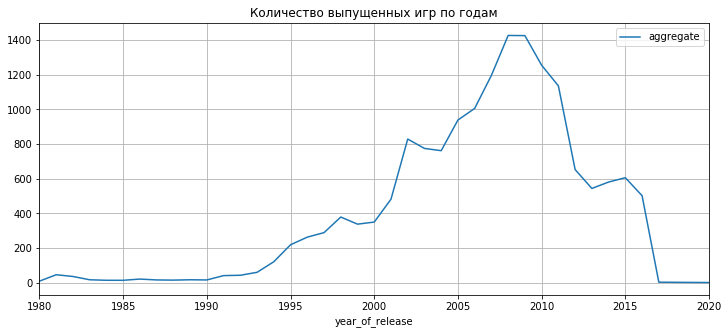

In [20]:
df_yr = df.pivot_table (index = 'year_of_release', values=['aggregate'], aggfunc='sum')
title_n = 'Количество выпущенных игр по годам' 
df_yr.plot(grid=True, figsize=(12, 5), title = title_n);

Если учитывать, что данные у нас только на 2015 год можно всё ровно можно сказать, что индустрия находится в кризисе. Хотя люди меньше играть не стали. Подъем в индустрии пошел с появлением платформы PS и продолжался аж до 2009 года до эры iphone 3gs когда в индустрии портативных устройств произошла революция и с того времени консоли стремительно идут вниз а поративные игры на мобильных платформах обретают обороты. Плюс развитие онлайн индустрии. Теперь людям не надо игр с сюжетом, да и производство таких игр требует очень много затрат, когда онлайн дота собирает миллионы.

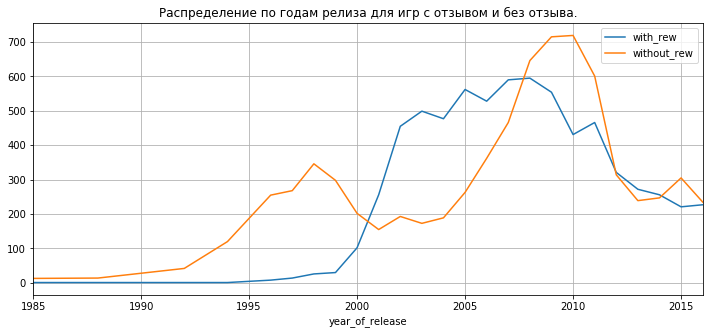

In [21]:
# Постройте распределение по годам релиза для игр с отзывом и без отзыва;
# cравните полученные распределения и сделайте вывод

df_h_rew = df.query('critic_score > 0 and user_score > 0')
df_n_rew = df.query('critic_score < 0 and user_score < 0') 

df_h_rew_pt = df_h_rew.pivot_table(index = 'year_of_release', values=['aggregate'], aggfunc='sum')
df_n_rew_pt = df_n_rew.pivot_table(index = 'year_of_release', values=['aggregate'], aggfunc='sum')

df_done = df_h_rew_pt.merge(df_n_rew_pt, how='inner', on='year_of_release')

columns = ['with_rew','without_rew']
df_done.columns = columns

title_n = 'Распределение по годам релиза для игр с отзывом и без отзыва.'
df_done.plot(grid=True, figsize=(12, 5), title = title_n);

Очень интересный график, Объяснить его я могу так. Обзор игр, это тоже индустрия у нас как я понимаю один или два источника рейтинга, может какой то портал а может журнал или журнал перешедший в онлайн портал - это очень важно для этого графика но неизвестно. По этому тут можно сказать, что обзор игр это тоже индустрия и она как и все начинания начинается с раскачивания. Когда люди не сразу понимают зачем им это. Так происходит и тут оборот игр набирает обороты но смежные индустрии не успевают за показателями продаж. Если присоединить предъидущий график мы видим молнееносный взлет индустрии а значит и прикованное внимание людей к ней, где и возрастает игры с оценкой, так как все, что на "хайпе" то и валантильно в всех отношениях. Дальше рост игр без оценки я могу объчнить начинающейся популярности youtube.

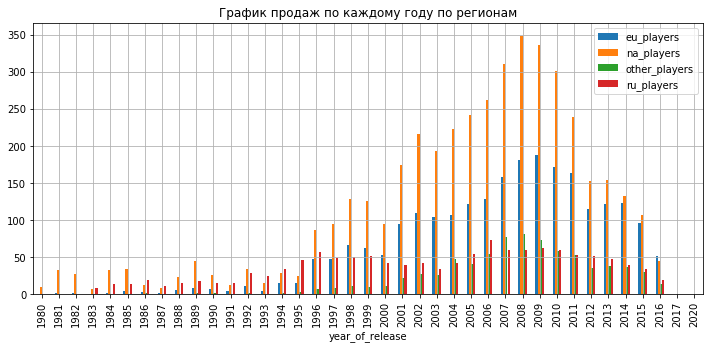

<Figure size 432x288 with 0 Axes>

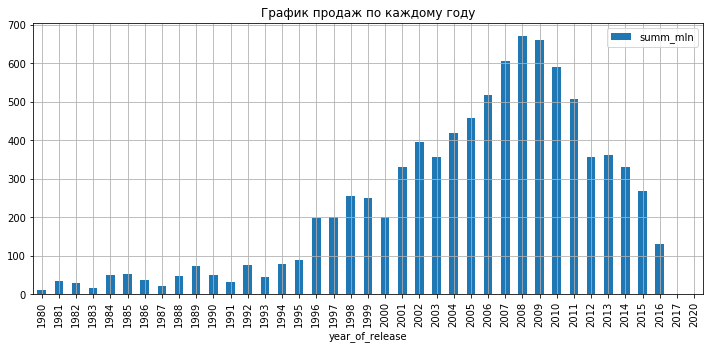

In [22]:
#Постройте график продаж по каждому году; сделайте вывод
df_yr_pr = df.pivot_table(index = 'year_of_release', 
                                values=['na_players', 'eu_players','ru_players','other_players'], aggfunc='sum')


title_n = 'График продаж по каждому году по регионам'
df_yr_pr.plot.bar(grid=True,figsize=(12, 5), title = title_n);

df_yr_pr['summ_mln'] = df_yr_pr['na_players'] + df_yr_pr['eu_players'] + df_yr_pr['ru_players'] + df_yr_pr['other_players']


df_yr_pr.drop('na_players', axis=1, inplace=True)
df_yr_pr.drop('eu_players', axis=1, inplace=True)
df_yr_pr.drop('ru_players', axis=1, inplace=True)
df_yr_pr.drop('other_players', axis=1, inplace=True)

plt.figure();

title_n = 'График продаж по каждому году';
df_yr_pr.plot.bar(grid=True, figsize=(12, 5), title = title_n);

График практически повторяет распределение продаж по годам.

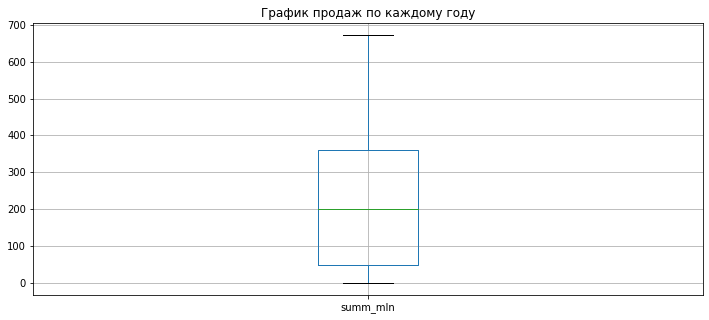

In [23]:
# Постройте ящик с усами по глобальным продажам, опишите полученный результат
title_n = 'График продаж по каждому году';
df_yr_pr.plot.box(grid=True, figsize=(12, 5), title = title_n);

Межпромежуточный размах варируется в пределах от 50 до 350. Выбросов не видно. Видно, по растоянию усов, что график смещен в право. Медиана это ширика ящика, но количественный показатель сказать не могу, известно, что он чуть меньши межквартильного размаха.

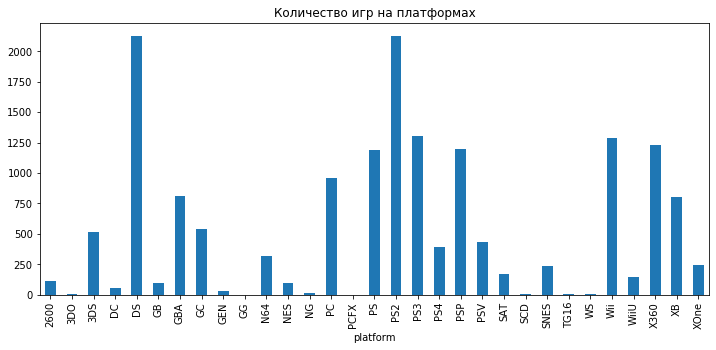

In [24]:
# Узнайте, на какой платформе было выпущено больше всего игр
df_platform = df.groupby('platform')['aggregate'].sum()
title_n = 'Количество игр на платформах'
df_platform.plot.bar(figsize=(12, 5), title = title_n);

Самой популярной алтформой является nindendo ds портативная консоль, Наверное это можно обуславить размерами и ценой Это вещь которую всегда можно иметь при себе, она компактная и небольшая. Дальше огромная популярность обрела PS2 это была приставка с лучшей графикой на то время а дальше в индустрии появились конкуренты которые уже хорошо видно на графике PS3, Wii, X360. 

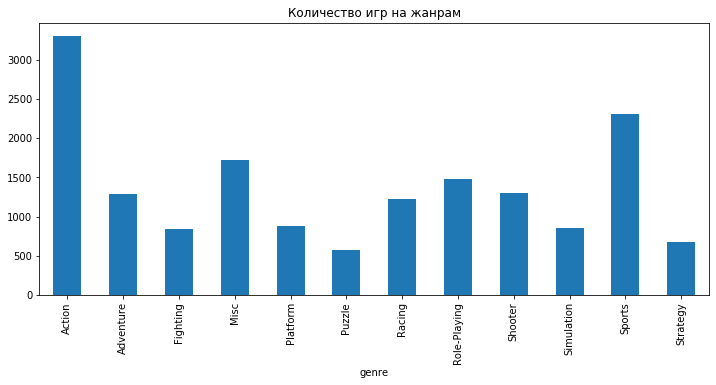

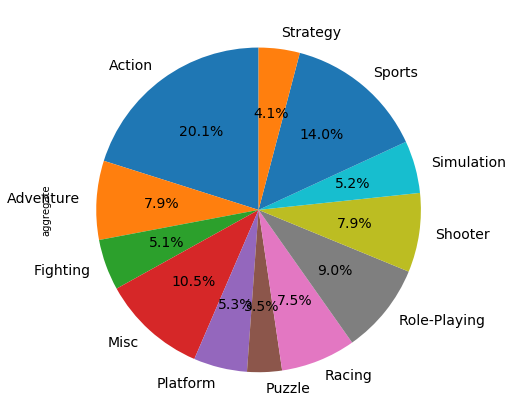

In [25]:
# Определите, игр какого жанра больше всего
df_genre = df.groupby('genre')['aggregate'].sum()
title_n = 'Количество игр на жанрам'
df_genre.plot.bar(figsize=(12, 5), title = title_n);

df_pt_na = df.pivot_table (index = 'genre', values=['aggregate'], aggfunc='sum').reset_index()

df_pt_na['aggregate_sum'] = df_pt_na['aggregate'].sum()

plt.figure(figsize=(16,8))
ax1 = plt.subplot(121, aspect='equal')
df_pt_na.plot(kind='pie', y = 'aggregate', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=df_pt_na['genre'], legend = False, fontsize=14);



Самыми поплурными жанрами оказались:
* action - 20%
* sport - 14%
* misc - 10.5%

In [26]:
# Найдите игры с наибольшей и наименьшей оценкой от пользователей
df_user_score_ = df.query('user_score > 0')
df_user_score_min = df_user_score_.sort_values(by = 'user_score', ascending = True).head()
print('Игры с наименьшей оценкой от пользователей')
print(df_user_score_min[['name','user_score']].head())
print()
print('Игры с наибольшей оценкой от пользователей')
df_user_score_max = df_user_score_.sort_values(by = 'user_score', ascending = False).head()
print(df_user_score_max[['name','user_score']].head())

Игры с наименьшей оценкой от пользователей
                                             name  user_score
13683              Myth Makers: Trixie in Toyland         0.2
9971                                Madden NFL 17         0.2
5764                                   Happy Feet         0.3
13381  Billy the Wizard: Rocket Broomstick Racing         0.3
10263           Charlie and the Chocolate Factory         0.5

Игры с наибольшей оценкой от пользователей
                                        name  user_score
14414                     Breath of Fire III         9.7
3417   Harvest Moon: Friends of Mineral Town         9.6
8976         Boktai: The Sun is in Your Hand         9.6
1645                Golden Sun: The Lost Age         9.5
5920                     MLB SlugFest Loaded         9.5


In [48]:
# Найдите игры с наибольшей и наименьшей оценкой от критиков
df_critic_score_ = df.query('critic_score > 0')
df_critic_score_min = df_critic_score_.sort_values(by = 'critic_score', ascending = True).head()
print('Игры с наименьшей оценкой от критиков')
print(df_critic_score_min[['name','critic_score']].head())
print()
print('Игры с наибольшей оценкой от критиков')
df_critic_score_max = df_critic_score_.sort_values(by = 'critic_score', ascending = False).head()
print(df_critic_score_max[['name','critic_score']].head())

Игры с наименьшей оценкой от критиков
                                      name  critic_score
13690                         Ride to Hell          13.0
10663  Leisure Suit Larry: Box Office Bust          17.0
10016                             Rugby 15          19.0
15345                        Balls of Fury          19.0
12132                            Anubis II          19.0

Игры с наибольшей оценкой от критиков
                          name  critic_score
51         Grand Theft Auto IV          98.0
227   Tony Hawk's Pro Skater 2          98.0
57         Grand Theft Auto IV          98.0
5350               SoulCalibur          98.0
1877                   NFL 2K1          97.0


<font color='green'>
Так как я сам не играл в эти игры и даже названия их мне не о чем не говорят да и присоединение жанра мало о чем расскажет в этой выборки то тут мы можем сказать одну важную вещь, что оценка критиков на пиках наивысших и наименьших оценок ни в одной игре не пересекается с оценкой пользовтелей. Что очень интересно, Зачем вообще тогда эти журнылы и обзоры?)
</font>

<font color='grey'>
Комментарий от наставника v2: Совершенно верно! Интересно, что топ-5 совершенно разные. Из этого можно сделать предположение о том что рейтиги от критиков и от пользователей не всегда пересекаются -- и в дальнейшем низкие значения коррелиции могут подтвердить это предположение.
</font>

In [28]:
# Оцените корреляцию между оценками критиков и пользовательскими оценками.
df_for_corr = df.query('critic_score > 0 and user_score > 0')
corr_critic = round(df_for_corr['critic_score'].corr(df_for_corr['user_score']),2)
print(f'Корреляция между оценкой пользователей и критиков составляет {corr_critic}')

Корреляция между оценкой пользователей и критиков составляет 0.58


Связь в 0.58 говорит о том, что связь между рейтингами есть но не очень сильная.

# Портрет пользователя для каждого региона

* топ-5 предпочтительных жанров
* в какие года пользователи были наиболее активны (больше всего покупали игры)
* топ-5 предпочтительных платформ
* какой рейтинг ESRB встречается чаще всего (наиболее частотная категория)

In [29]:
def best_seller_at_genre(df, column_agg):
    
    df_pt_na = df.pivot_table (index = 'genre', values=[column_agg], aggfunc='sum')
    df_pt_na = df_pt_na.sort_values(by = column_agg, ascending = False).head()
    title_n = 'Топ 5 предпочтительных жанров по количеству дохода от продаж.'

    df_pt_na.plot.pie(subplots=True, figsize=(8, 4), title = title_n)

In [30]:
def best_seller_at_year(df, column_agg):
    
    df_pt_na = df.pivot_table (index = 'year_of_release', values=[column_agg], aggfunc='sum')
    title_n ='Активность по годам от количества дохода от продаж.'
    df_pt_na.groupby('year_of_release').sum().plot(kind='bar', rot=1000, figsize=(12, 5), title = title_n)    

In [31]:
def best_seller_at_platform(df, column_agg):
    
    df_pt_na = df.pivot_table (index = 'platform', values=[column_agg], aggfunc='sum')
    df_pt_na = df_pt_na.sort_values(by = column_agg, ascending = False).head()
    title_n = 'Топ 5 предпочтительных платформ по количеству дохода от продаж.'
    
    df_pt_na.plot.pie(subplots=True, figsize=(8, 4), title = title_n)

In [32]:
def best_ESRB_5(df, column_agg):
    
    critic_score = column_agg
    df_esbr = df.query(column_agg +' > 0 and rating != "Unknown"')
    
    df_pt_na = df_esbr.pivot_table (index = 'decryption', values=['aggregate'], aggfunc='sum')
    df_pt_na = df_pt_na.sort_values(by = 'aggregate', ascending = False).head()
    title_n = 'Топ 5 частотных категорий рейтинга ESBR'
    df_pt_na.plot.bar(figsize=(12, 5), title = title_n);
    

In [33]:
def look_at_grafic(column_agg):
    
    best_seller_at_genre(df, column_agg)
    best_seller_at_platform(df, column_agg)
    best_seller_at_year(df, column_agg)
    best_ESRB_5(df, column_agg)
    

## Портрет пользователя для региона - Серверная Америка

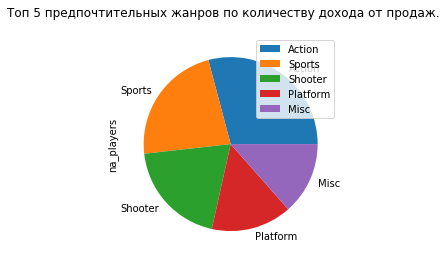

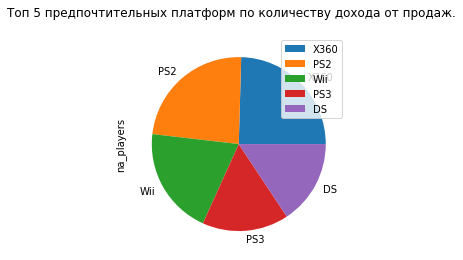

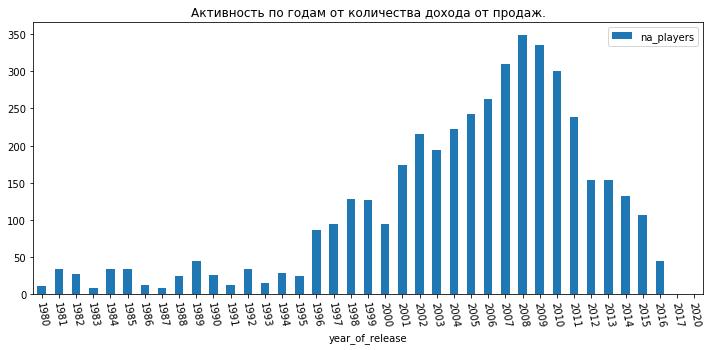

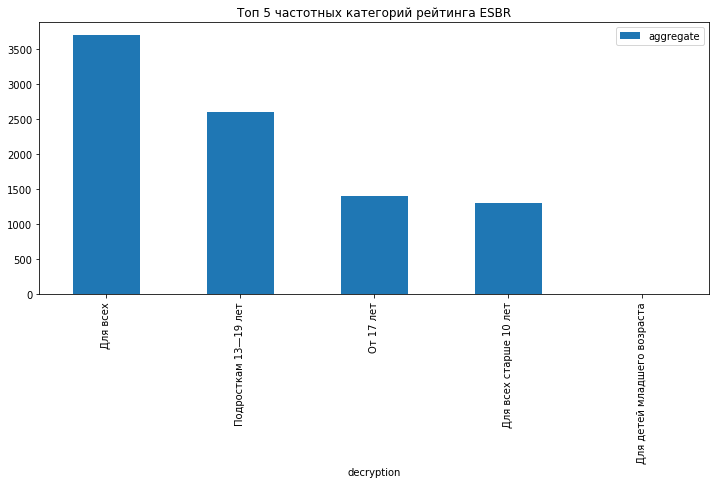

In [34]:
warnings.filterwarnings('ignore') # Убрал предупреждение, так красивее)
look_at_grafic('na_players')

## Портрет пользователя для региона - Странах Европы

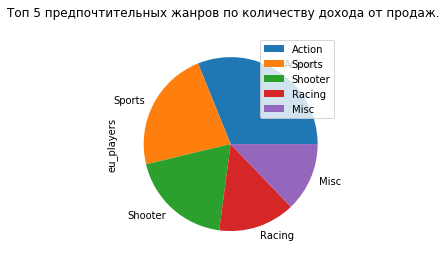

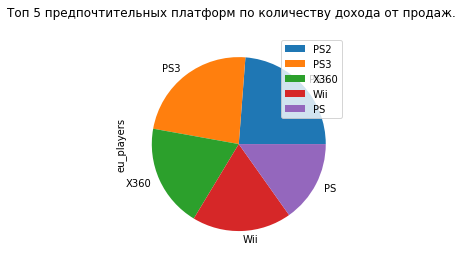

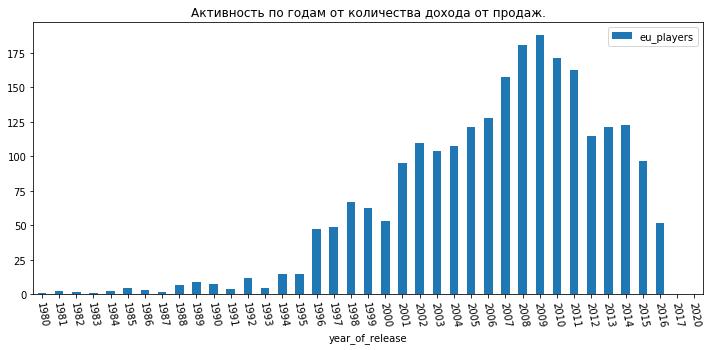

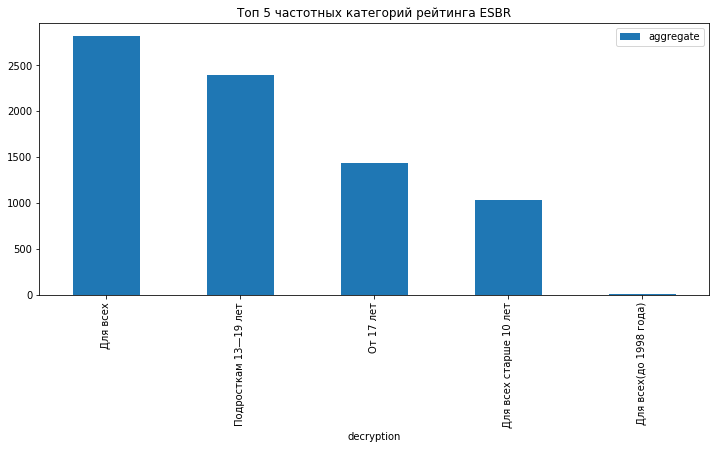

In [35]:
look_at_grafic('eu_players')

## Портрет пользователя для региона - Россия

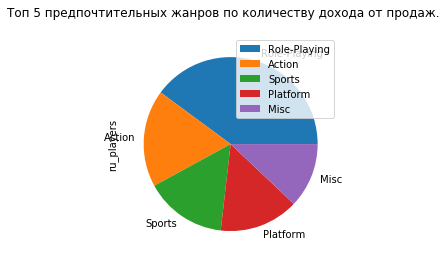

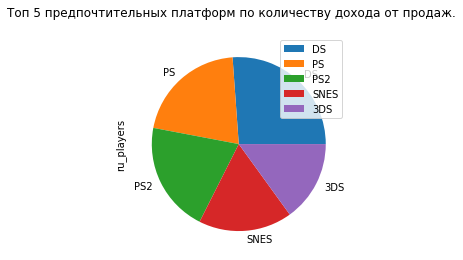

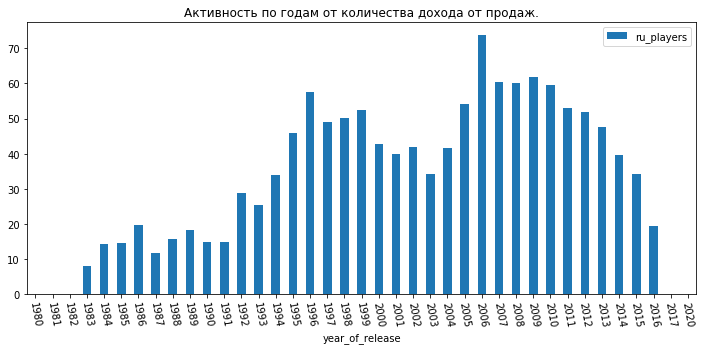

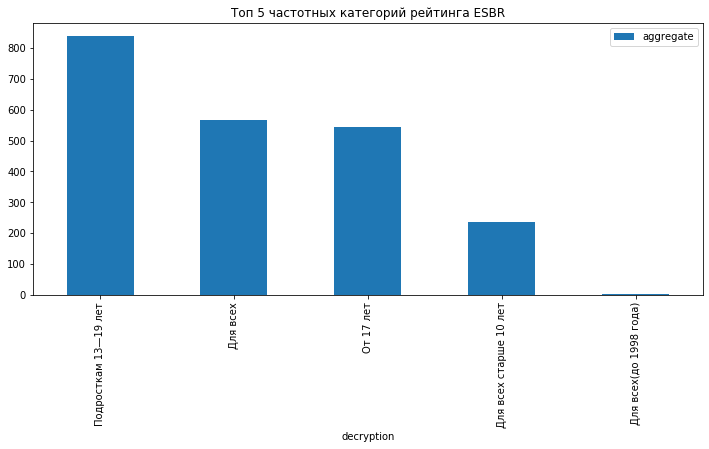

In [36]:
look_at_grafic('ru_players')

## Портрет пользователя для региона - другие страны

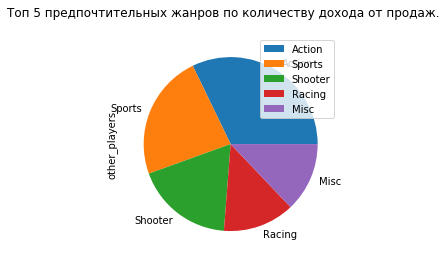

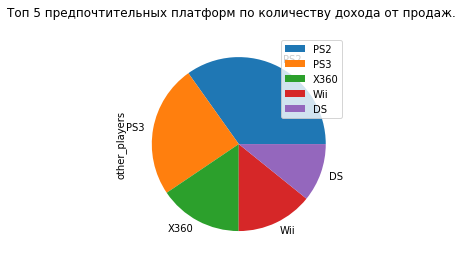

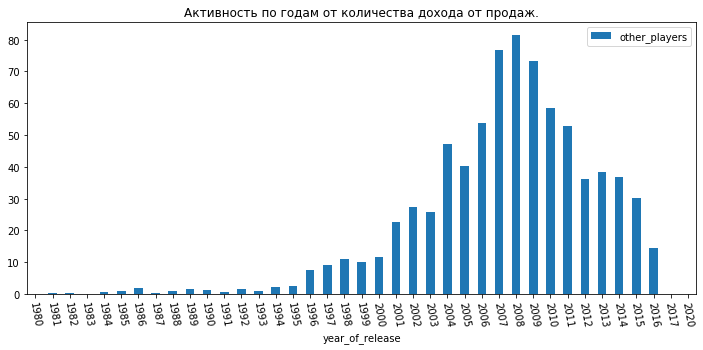

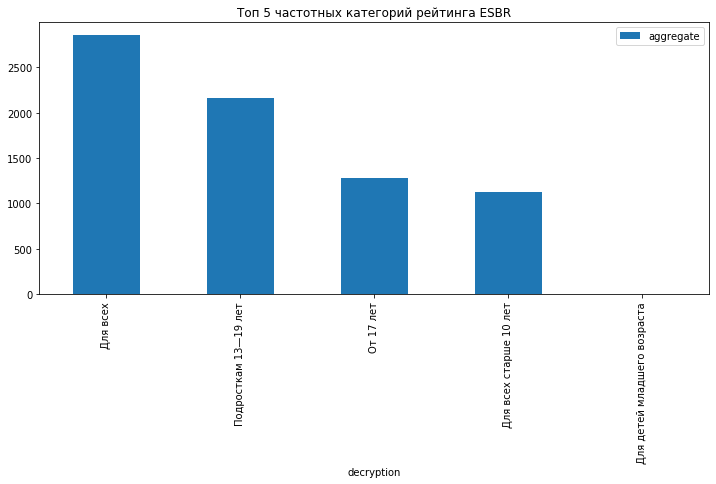

In [37]:
look_at_grafic('other_players')

<font color='green'>
 У нас 4 портрета пользователей, представляющих: Сереврную Америку, Россию, Европу и Остальные страны. По показателям продаж можно сразу похвалить родной рынок. кривая продаж с 1992 года деражалась на хорошем уровне и сильных потрясений рынка не было, да и до сих порт когда индустрвия в кризисе то по этому графику можно сказать, что пользователи еще испытывают интерес к консольным играм. Самые популярные консоли nindendo и семейство консолей PS. Любимый жанр - Role-action, Activ and Sport. По выручке стаблиьно держится в районе 50-60 млн. и 80 млн. в пике.

* Для жителей Америки Рынок начал резко рости примерно в 1998 году и достиг пика в 2010 году Дальше был резкий спад. В смысле консолей американский рынок патриотичен и на ровне использует как Xbox 360, Wii и  платформы PS, из жанров игр предпочитают Action, Sport and Shooter. Рынок Америки это самый большой по выручке от продаж. С показателем 350 млн. он опережает в два и в три раза остальные рынки.
* Европа - резкий рост продаж начинается в 1996 году и продолжается до 2008 года. Предпочтения очень схожи с рынком Северной Америки. В качестве платформы используется семейство приставок PS и xBox 360. Жанры  Action, Sport и Shooter. Объем продаж 180 млн. в пике продаж. 
* Остальной мир - отстает от показателей Европы и Америки и находится на уровне России по объемам продаж но кривая интереса от если судить от объема продаж очень сильно различается. В России эта кривая более плавная тогда как в Остальном мире мы видим очень четкий пик в 2008 году. Консоли для игра очень похожи с рынком Европы PS нескольких поколений и Xbox 360. Жанры Action sport and Shooter как в многих других местах стоят здесь на первом месте.
* Для всех категорий видна одна взаимосвязь на третьем месте по объему продаж во всех странахв стоти жанр от 17 и старше а на первых местах жанры "Для всех" и "Подростки", что впринципе логично так как основные пользовтели консолей школьники и подростки. 
</font>

# Проверьте гипотезы:

* Средний пользовательский рейтинг платформ PS2 и PS3 одинаковый;
* Средний пользовательский рейтинг жанров Action и Sports различается.
* Пороговое значение alpha задайте самостоятельно.

_Поясните:
как вы формулировали нулевую и альтернативную гипотезы;
какой критерий использовали для проверки гипотез и почему._

### _Средний пользовательский рейтинг платформ PS2 и PS3 одинаковый?_

* Нулевая гипотеза: Средний пользовательский рейтинг игровых платформ PS2 и PS3 одинковый.
* Альтернативная гипотеза: Средний пользовательский рейтинг игровых платформ PS2 и PS3 различается.

* Для исследования будем использовать гипотезу о равенстве средних двух генеральных совокупностей.
* Критический уровень статистической значимости установим в нормальных пределах - 0.5

In [46]:
df_ps2 = df.query('platform == "PS2" and user_score > 0')
df_ps3 = df.query('platform == "PS3" and user_score > 0')

#df_ps2 = df_ps2.head(861); # приведем массивы к одной численности

In [47]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    df_ps2['user_score'], 
    df_ps3['user_score'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.326216083163738e-47
Отвергаем нулевую гипотезу


### _Средний пользовательский рейтинг жанров Action и Sports различается._

* Нулевая гипотеза: Средний пользовательский рейтинг жанров Action и Sports различается.
* Альтернативная гипотеза: Средний пользовательский рейтинг жанров Action и Sports равен

* Для исследования будем использовать гипотезу о равенстве средних двух генеральных совокупностей.
* Критический уровень статистической значимости установим в нормальных пределах - 0.5

In [44]:
df_action = df.query('genre == "Action" and user_score > 0')
df_sports = df.query('genre == "Sports" and user_score > 0')

#df_action = df_action.head(1081); # приведем массивы к одной численности

<font color='blue'>
Комментарий от наставника: Зачем приводить к одной численности? И пользуешься ли ты тут критерием для выборок с одинаковой дисперсией?
</font>

<font color='green'>
Да, я напутал с темой о парной выборке). Закомментировал строку и совсем другой результат!)
</font>

<font color='grey'>
Комментарий от наставника v2: Да, совершенно верно!) Хорошо, что разобрался) 
</font>

In [45]:
alpha = .01 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    df_action['user_score'], 
    df_sports['user_score'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.06480928064420527
Не получилось отвергнуть нулевую гипотезу


# Общий вывод

Классическая индустрия консольных игр на сегоднешний день находится в кризисе. Мы видим резкий спад после 2008 года и наверное на сегоднешний день консоль не является приоритетным инструментом развлечения так как и тогда людям нравилась компактность(на примере платформы DS) так и сейчас поиграть в игру человек может и на телефоне, а всем остальным достаются отдельные группы граждан на типу тех кому нравится пластинки и он готов содержать дома всю эту технику для их проигрованию. когда в музыкальнй индустрии прошли очень похожие процессы.
    * Актуального и на сегодняшний день можно сказать о жанрах которые предпочитают пользователи - это конечно же Aсtion и после Sport это всегда были две основные категории, а вот на третье место мода была сменяема. Когда это были гонки когда шутеры.
    * Самая популярная консоль, конечно же PS2 на нее пришло золотое вермя этой индустрии а потом конкуреты поняли на сколько этот рынок большой и вышли уже с своими платформами, такими как Wii и X360 которые и разбили рынок примерно на равные части с следующим поколение PS3.
    * А самой игровой страной по доходу от продаж игр является Россия (она же Япония) и спад в индустрии здесь чувствуется нименьше всего, что не скажешь о продажах в Серевной Америки.

<font color='green'>
    
    * Игровая индустрия начала активно развиваться в с 1990 года на тот момент было около 50 игр. в выборке и к 2008 году эта цифра состовляет в 1400 коробок с разными играми на сеодняшний день производство снизилось в довое.
    * Оценка пользователей и критиков коррелируют но очень слабо. И если смотреть график распределения игр с рецензией и без можно сказать, что эта индустрия появилась в 2008 году а начала активно развиваться и на сегодняшний день корелирует с общим объемом продаж. Интересно, что большинство игр до сих пор остается без рецензии.
    * самые популярные консоли это DS для нее было выпущено за все вермя около 2000 игр как и для платформы PS2. Дальше в районе 1100-1250 игр разделяется между собой платформами PSP, Wii, PS, PS3. Xbox360.
    * В Исследование учавствую 4 рынка сбыта: Серверная Америка, Россия, Европа и остальной мир. Если подъитожить показатели можно сказать:
        - Серверная Америка - очень большой по объему рынок в 350 млн. дол в пике и в районе 100 млн. на сегоднешний день. Любимые жанры Action, Sport и Shooter. Самая популярная консоль Xbox 360 и PS2
        - Россия - в России начали играть сразу после путча 1993 года. Судя по всему в жанр Ролевых игр. Показатели пика рынка в районе 70 млн. дол. в 2007 году и давольно плавная валантильность индустрии на сегодняшний день. на втором месте по жанрам стоит Action дальше идет Sport.
        - Европа. Доход от продаж в пике 2009 года 180 млн. дол. Любимый жанр Action, Sport и Shooter. Любимые платформы PS2 и PS3.
        - Для других стран если смотреть в перпективе на весь мир это давольно сромные показатели в районе 80 млн. дол. в пике 2008 года. Самой популярной консолью является семейство PS и очень схожие жарны с остальным миром кроме России где на перво месте стоит Role-Playing.
        
</font>   
    

<font color='green'>
    Гипотезы:
    
* Для проверки гипотез. Как нулевую определяем Равен ли средний рейтинг консолей PS2 и PS3.
    * расчеты показали, что при критическом уровне статистической погрешности в 5% мы отвергаем отвергаем нулевую гипотезу и можем утвержадать, что средняя оценка у консолей PS2 и PS3 различается. Это объяснимо, что второе покаление консоли было популярно в времена низкой конкуренции как и первое на время выхода третьей версии рынок наполнился еще двумя гигантами в виде wii и xbox360. PS3 было очень сложно держать уровень пользовательских симпатий на прежнем уровне. 
    
* Для проверки второй гипотезы.  Средний пользовательский рейтигн двух жанров Action и Sport отличается, что задается как нулевой гипотезой. 
    * и в этот раз расчеты показывают, что отличие средних минимально и входит даже в 1% критического значения. Из чего мы можем сказать, что средний пользовательский рейтиг этих двух жанров очень похож.
</font>